# Starter Notebook for GeneTuring Few-shot Evaluation

Let's start of by implementing a basic harness to evaluate the Geneturing dataset using Ollama with a Few-Shot prompting strategy to evaluate the performance of these models before implementing the tool-using strategies outlined in the GeneGPT paper.

As with most benchmarking code using pretrained models, our notebook will following typical outline of:

1. **Imports**
2. **Configuration**
3. **Data Loading**
4. **Model Specification**
5. **Metrics**
6. **Evaluation Loop**
7. **Analysis**

## 1. Imports

Good hygiene for Jupyter notebooks includes placing all of the imports at the top of the notebook. This makes it easier to understand what dependencies are needed to run the notebook for new users and mirrors good practices for Python scripts.

In [ ]:
from dotenv import load_dotenv
import os
os.environ["no_proxy"] = "*"
load_dotenv()

AZURE_OPENAI_KEY = os.getenv("AZURE_OPENAI_KEY")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_DEPLOYMENT_NAME = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")
AZURE_OPENAI_API_VERSION = os.getenv("AZURE_OPENAI_API_VERSION")

print("Loaded API key:", AZURE_OPENAI_KEY[:5] + "..." if AZURE_OPENAI_KEY else "MISSING")


Loaded API key: FJ5Gr...


In [ ]:
from typing import List, Dict, Optional

from collections import defaultdict
from dataclasses import dataclass


## 2. Configuration

Also, let's create a section that is specific to the configuration of the run. This will make it easier to change the configuration of the run without hunting for hard-coded values sprinkled throughout the code and makes it easier for others to understand the configuration of the run.

We will leave it empty at the moment, but we will come back and fill it in as we identify global configuration options that we need to implement the code.

In [3]:
# 2.1 Data Configuration
data_config = {
    "dataset_path": "/work/bioinformatics/s440708/MODULE_3_MATERIALS/data/geneturing.json",  
    "output_path": "outputs/eval_outputs.json",

}


In [4]:
# 2.2 Model Configuration

model_config = {           
    "model_name": AZURE_OPENAI_DEPLOYMENT_NAME,         
    'frequency_penalty': 0.0,
    'presence_penalty': 0.0,
    "temperature": 1.,
    "max_tokens": 800,
    "top_p": 1.0,
    
}


In [5]:
# 2.3 Evaluation and Logging Configuration




## 3. Data Loading

In this section we need to load the data that we will be using for our evaluation. 

The JSON file at `data/gene_turing.json` contains a dictionary of dictionaries. At the top level, the keys are the names of the tasks. Within each task, there are several key-value pairs where the keys are the questions and the values are the answers.

Below is one example for each of the 9 tasks in the dataset:

```json
{
    "Gene alias": {
        "What is the official gene symbol of LMP10?": "PSMB10"
    },
    "Gene disease association": {
        "What are genes related to Hemolytic anemia due to phosphofructokinase deficiency?": "PFKL"
    },
    "Gene location": {
        "Which chromosome is FAM66D gene located on human genome?": "chr8"
    },
    "Human genome DNA aligment": {
        "Align the DNA sequence to the human genome:ATTCTGCCTTTAGTAATTTGATGACAGAGACTTCTTGGGAACCACAGCCAGGGAGCCACCCTTTACTCCACCAACAGGTGGCTTATATCCAATCTGAGAAAGAAAGAAAAAAAAAAAAGTATTTCTCT": "chr15:91950805-91950932",
    },
    "Multi-species DNA aligment": {
        "Which organism does the DNA sequence come from:AGGGGCAGCAAACACCGGGACACACCCATTCGTGCACTAATCAGAAACTTTTTTTTCTCAAATAATTCAAACAATCAAAATTGGTTTTTTCGAGCAAGGTGGGAAATTTTTCGAT": "worm",
    },
    "Gene name conversion": {
        "Convert ENSG00000215251 to official gene symbol.": "FASTKD5",
    },
    "Protein-coding genes": {
        "Is ATP5F1EP2 a protein-coding gene?": "NA",
    },
    "Gene SNP association": {
        "Which gene is SNP rs1217074595 associated with?": "LINC01270",
    },
    "SNP location": {
        "Which chromosome does SNP rs1430464868 locate on human genome?": "chr13",
    }
}
```


We need to reformat this into a pandas dataframe with the following columns:
- `id`: A serial ID number we will assign to each example (int)
- `task`: The name of the task (str)
- `question`: The question for the example (str)
- `answer`: The answer for the example (str)

The final dataframe we will create should look like this:

| id | task | question | answer |
|----|------|----------|--------|
| 0 | Task1 | Question1 | Answer1 |
| 1 | Task1 | Question2 | Answer2 |
| 2 | Task2 | Question1 | Answer1 |
| 3 | Task2 | Question2 | Answer2 |

In [6]:
# 3.1 Load the JSON file
# Load the data here
import json

def load_geneturing(path: str) -> List[Dict[str, str]]:
    with open(path, "r") as f:
        raw_data = json.load(f)

    flat_data = []
    counter = 0
    for task_name, qa_pairs in raw_data.items():
        for question, answer in qa_pairs.items():
            flat_data.append({
                "task": task_name,
                'id': counter,
                "question": question,
                "answer": answer
            })
            counter += 1
    

    return flat_data


# config = Config()
dataset = load_geneturing(data_config['dataset_path'])
print(f"Loaded {len(dataset)} examples from {data_config['dataset_path']}")
TASKS = set() 

Loaded 450 examples from /work/bioinformatics/s440708/MODULE_3_MATERIALS/data/geneturing.json


In [7]:
dataset

[{'task': 'Gene alias',
  'id': 0,
  'question': 'What is the official gene symbol of LMP10?',
  'answer': 'PSMB10'},
 {'task': 'Gene alias',
  'id': 1,
  'question': 'What is the official gene symbol of SNAT6?',
  'answer': 'SLC38A6'},
 {'task': 'Gene alias',
  'id': 2,
  'question': 'What is the official gene symbol of IMD20?',
  'answer': 'FCGR3A'},
 {'task': 'Gene alias',
  'id': 3,
  'question': 'What is the official gene symbol of C20orf195?',
  'answer': 'FNDC11'},
 {'task': 'Gene alias',
  'id': 4,
  'question': 'What is the official gene symbol of CXorf40B?',
  'answer': 'EOLA2'},
 {'task': 'Gene alias',
  'id': 5,
  'question': 'What is the official gene symbol of QSCN6L1?',
  'answer': 'QSOX2'},
 {'task': 'Gene alias',
  'id': 6,
  'question': 'What is the official gene symbol of OR11-86?',
  'answer': 'OR10A2'},
 {'task': 'Gene alias',
  'id': 7,
  'question': 'What is the official gene symbol of NPAP60L?',
  'answer': 'NUP50'},
 {'task': 'Gene alias',
  'id': 8,
  'questio

In [8]:
# 3.2 Iterate through the JSON data recursively to collect each of the rows into a list
#     Each row should have a dictionary with keys of the columsn in the table above


# def flatten_geneturing_json(raw_data) -> List[Dict[str, str]]:

#     flat_data = []
#     counter = 0

#     for  in raw_data:
#         for question, answer in qa_pairs.items():
#             row = {
#                 "id": counter,
#                 "task": task_name,
#                 "question": question,
#                 "answer": answer
#             }
#             flat_data.append(row)
#             counter += 1

  

#     return flat_data

# dataset = flatten_geneturing_json(dataset)
# print(f"Flattened to {len(dataset)} rows.")


In [9]:
# 3.3 Create the pandas dataframe from the collection of rows

import pandas as pd

def build_dataframe(flat_data: List[Dict[str, str]]) -> pd.DataFrame:

    df = pd.DataFrame(flat_data)
    
    df = df[["id", "task", "question", "answer"]]  
    df.set_index("id", inplace=True)
    return df

df = build_dataframe(dataset)
print(f"DataFrame shape: {df.shape}")
display(df.head())

DataFrame shape: (450, 3)


,task,question,answer
id,,,
0,Gene alias,What is the official gene symbol of LMP10?,PSMB10
1,Gene alias,What is the official gene symbol of SNAT6?,SLC38A6
2,Gene alias,What is the official gene symbol of IMD20?,FCGR3A
3,Gene alias,What is the official gene symbol of C20orf195?,FNDC11
4,Gene alias,What is the official gene symbol of CXorf40B?,EOLA2


## 4. Model Specification

With our few-shot in-context learning model, we need to specify four components:

1. The large language model to use
2. The instructions for the model as a system prompt
3. The few-shot examples to provide to the model to demonstrate the input-output format
4. The completion request function that puts it all together retrieving a response for each unseen input

### 4.1 Setting up the large language model

We will use the Ollama client to interface with the large language model on the Ollama server we started. With large language models, it is common to use a client library to interface with the model hosted by a server. This allows us to iterate quickly on the prompting and post-processing logic without having to incur the overhead of loading the model into memory each time.  Additionally, model code is oftentimes optimized for inference.

In [10]:
# from ollama import Client
# client = Client(
#   host='http://localhost:11434',
# )
# response = client.chat(model='qwen3:4b', messages=[
#   {
#     'role': 'user',
#     'content': 'Why is the sky blue?',
#   },
# ])

In [11]:
# 4.1 Setting up the large language model Ollama model client
from openai import AzureOpenAI

OllamaClient = AzureOpenAI(
    api_version=AZURE_OPENAI_API_VERSION,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_KEY,
)

response = OllamaClient.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant.",
        },
        {
            "role": "user",
            "content": "I am going to Paris, what should I see?",
        }
    ],
   
    max_completion_tokens=model_config['max_tokens'],
    temperature=model_config['temperature'],
    top_p=model_config['top_p'],
    frequency_penalty=model_config['frequency_penalty'],
    presence_penalty=model_config['presence_penalty'],
    model=model_config['model_name']

)

print(response.choices[0].message.content)


How exciting! Paris is filled with iconic landmarks, world-class museums, beautiful neighborhoods, and delicious food. Here are some top recommendations to help you plan your trip:

### Iconic Sights
- **Eiffel Tower**: Go up for city views or picnic in the Champ de Mars park below.
- **Louvre Museum**: See the Mona Lisa, the Venus de Milo, and countless masterpieces.
- **Notre-Dame Cathedral**: Although restoration is still ongoing, the exterior is impressive and the nearby Île de la Cité is lovely to stroll around.
- **Arc de Triomphe**: Climb to the top for panoramic views of the Champs-Élysées and Paris.
- **Sacre-Cœur Basilica**: Perched atop Montmartre hill, with great views and a charming neighborhood to explore.

### Neighborhoods to Explore
- **Le Marais**: Trendy boutiques, cafés, and the historic Place des Vosges.
- **Montmartre**: Bohemian charm, artists in Place du Tertre, and vintage shops.
- **Latin Quarter**: Bookshops (like Shakespeare & Co.), Sorbonne University, and 

### 4.2 Setting up the system prompt

Modern large language models are post-trained to perform a variety of tasks and follow instructions. To leverage this capability, we need to provide a system prompt that clearly outlines the task, any constraints, and the format of the output.

Designing the system prompt is a critical aspect of using LLMs. Below are several resources for designing a system prompt:
* [OpenAI Prompt Engineering](https://platform.openai.com/docs/guides/text?api-mode=responses#prompt-engineering)
* [Kaggle/Google Prompt Engineering](https://www.kaggle.com/whitepaper-prompt-engineering?_bhlid=a2bfce2cac67662098bd85a241e7cb000576e5d4)
* [Anthropic Prompt Engineering](https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/overview)
* [OpenAI GPT 4.1 Prompting Cookbook](https://cookbook.openai.com/examples/gpt4-1_prompting_guide)


**From the OpenAI Prompt Engineering guide:**

> **Identity**: Describe the purpose, communication style, and high-level goals of the assistant. 
> 
> **Instructions**: Provide guidance to the model on how to generate the response you want. What rules should it follow? What should the model do, and what should the model never do? This section could contain many subsections as relevant for your use case, like how the model should call custom functions.  
>
> **Examples**: Provide examples of possible inputs, along with the desired output from the model.  
> 
> **Context**: Give the model any additional information it might need to generate a response, like private/proprietary data outside its training data, or any other data you know will be particularly relevant. This content is usually best positioned near the end of your prompt, as you may include different context for different generation requests.  

This is what the system prompt looked like in the originalGeneGPT paper, but it is not the best. Identify what it includes and what is missing. Implement your own system prompt incorporating best practices from some of the guides posted above. 

> 	'Hello. Your task is to use NCBI Web APIs to answer genomic questions.'

In [12]:
# 4.2 Draft your own system prompt for our generic genomics question answering system. 
#     Replace the system message `content` below with your own.
system_message = [
    {
        "role": "system",
        "content": "You are a genomic assistant. When answering questions, return only the final answer."
         "Do not include explanations, references, or formatting. For example, only reply 'chr1:123-456'"
        "or 'GNAS' without additional context."
    }
]

### 4.3 Setting up the few-shot examples

For tasks with idiosyncratic output formats or constraints, it is important to provide clear instructions as well as examples to guide the model in generating the desired output. Mechanically, we provide these pairs of inputs and outputs as a sequence of user and assistant messages after the system prompt.

```python
messages += [
    {
        "role": "user",
        "content":  <fill in input example 1>
    },
    {
        "role": "assistant",
        "content": <fill in output example 1>
    },
    {
        "role": "user",
        "content": <fill in input example 2>
    },
    {
        "role": "assistant",
        "content": <fill in output example 2>
    }
]
```

In the GeneGPT code, the authors included several tasks, one of each of a subset of the tasks in the dataset. We will use the same examples here.

Please inspect the GeneGPT repository to find the few-shot examples in the prompt. 

Specifically the `get_prompt_header` function in `main.py` located here: [main.py](https://github.com/ncbi/GeneGPT/blob/main/main.py)

In [13]:
# 4.3 Appending the few-shot examples to the `messages` list

example_messages = [
    {
        "role": "user",
        "content": "hello"
    },
    {
        "role": "assistant",
        "content": "hello"
    },
    {
        "role": "user",
        "content": "hello"
    },
    {
        "role": "assistant",
        "content": "hello"
    }
]



### 4.4 Implementing the model request function

Now we need to put it all together. We need a function that accepts as arguments:
1. The client
2. The system message
3. The few-shot examples
4. The new user query -- this case the user's question from the GeneTuring dataset.

The function should return the response from the model and extract the answer (everything after 'Answer :' based on the format of the examples above)



In [14]:
def query_model(
    client,  
    system_message: dict,
    few_shot_examples: List[dict],
    user_query: str,
) -> str:
    
    messages = [system_message] + few_shot_examples + [{"role": "user", "content": user_query}]

    response = client.chat.completions.create(
        model=model_config['model_name'],
        messages=messages,
        max_tokens=model_config['max_tokens'],
        temperature=model_config['temperature'],
        top_p=model_config['top_p'],
        frequency_penalty=model_config['frequency_penalty'],
        presence_penalty=model_config['presence_penalty'],
    )
    


    return response.choices[0].message.content


## 5. Metrics

The GeneTuring dataset has several task specific evaluation metrics that are variations on exact match depending on the expected cardinality of the output.

Please inspect `evaluate.py` from the GeneGPT repository to find the metric functions and implement them here.

Original functions: [evaluate.py](https://github.com/ncbi/GeneGPT/blob/main/evaluate.py)

* **Default exact match** - The predicted answers and ground truth are both strings. The score is 1 if they are equal and 0 otherwise
* **Gene disease association** - The predicted answers and ground truth are both lists of gene-disease associations. The score is the proportion of correct associations present in the prediction
* **Disease gene location** - The predicted and true answers are lists (e.g., gene locations related to a disease), and the evaluation calculates the fraction of the correct items present in the prediction.
* **Human genome DNA aligment** - 1 point for exact match, 0.5 point if chrX part matches, 0 otherwise

In [15]:
# 5.1 Implement metrics

def exact_match(pred: str, true: str) -> float:
    # if isinstance(pred, list):
    #     pred = [p.strip().lower() for p in pred]
    #     return float(true.strip().lower() in pred)
    # else:
    #     return float(pred.strip().lower() == true.strip().lower())
    return float(pred.strip().lower() == true.strip().lower())


def gene_disease_association(pred: list, true: list) -> float:
    pred_set = set(map(str.lower, map(str.strip, pred)))
    true_set = set(map(str.lower, map(str.strip, true)))
    if not true_set:
        return 1.0 if not pred_set else 0.0
    return len(pred_set & true_set) / len(true_set)

def disease_gene_location(pred: list, true: list) -> float:
    pred_set = set(map(str.lower, map(str.strip, pred)))
    true_set = set(map(str.lower, map(str.strip, true)))
    if not true_set:
        return 1.0 if not pred_set else 0.0
    return len(pred_set & true_set) / len(true_set)
    
def human_genome_dna_alignment(pred: str, true: str) -> float:
    pred = pred.strip().lower()
    true = true.strip().lower()
    if pred == true:
        return 1.0
    pred_chr = pred.split(':')[0]
    true_chr = true.split(':')[0]
    return 0.5 if pred_chr == true_chr else 0.0

metric_task_map = defaultdict(lambda: exact_match, {
    "Gene disease association": gene_disease_association,
    "Gene location": disease_gene_location,
    "Human genome DNA aligment": human_genome_dna_alignment
})


Many of the gold-answers are in a specific format. `evaluate.py` also implements an answer post-processing function `get_answer` to better align model outputs with the gold answers. We also need to implement a similar function.

In [16]:
def get_answer(answer, task):

	mapper = {'Caenorhabditis elegans': 'worm',
			  'Homo sapiens': 'human',
			  'Danio rerio': 'zebrafish',
			  'Mus musculus': 'mouse',
			  'Saccharomyces cerevisiae': 'yeast',
			  'Rattus norvegicus': 'rat',
			  'Gallus gallus': 'chicken'}

	if task == 'SNP location':
		answer = answer.strip().split()[-1]
		if 'chr' not in answer:
			answer = 'chr' + answer

	elif task == 'Gene location':
		answer = answer.strip().split()[-1]
		if 'chr' not in answer:
			answer = 'chr' + answer

	elif task == 'Gene disease association':
		answer = answer.strip().replace('Answer: ', '')
		answer = answer.split(', ')

	elif task == 'Disease gene location':
		answer = answer.strip().replace('Answer: ', '')
		answer = answer.split(', ')

	elif task == 'Protein-coding genes':
		answer = answer.strip().replace('Answer: ', '')
		if answer == 'Yes':
			answer = 'TRUE'
		elif answer == 'No':
			answer = 'NA'

	elif task == 'Multi-species DNA aligment':
		answer = answer.strip().replace('Answer: ', '')
		answer = mapper.get(answer, answer)

	else:
		answer = answer.strip().replace('Answer: ', '')
		
	if isinstance(answer, list):
		answer = answer[0]
	return answer


## 6. Evaluation Loop

Now, let's implement the evaluation loop for the GeneTuring dataset. For now we will call the model function one at a time and collect the results in a list. Also, we will collect per-task metrics and the overall metrics for the dataset as we go. Once we're done, we will save the results to a CSV file.

In [17]:
# 6.1 Set up data structures for results
from dataclasses import asdict

@dataclass
class Result:
    id: int
    task: str
    question: str
    answer: str
    raw_prediction: Optional[str]
    processed_prediction: Optional[str]
    score: Optional[float]
    success: bool


def save_results(results: List[Result], results_csv_filename: str) -> None:
    df = pd.DataFrame([asdict(r) for r in results])
    df.to_csv(results_csv_filename, index=False)



In [18]:
# 6.2 Loop over the dataset with a progress bar

# * Do not forget to add the results to our Result list, both successful and failed predictions
# * API calls will not always work, so make sure we capture the exceptions from failed calls
#    and add them to the Result list with a `status=False`

from tqdm import tqdm
from typing import List, Dict

def evaluate_with_progress(
    client,
    dataset: List[Dict],
    system_message: Dict,
    few_shot_examples: List[Dict],
) -> List[Result]:
    results: List[Result] = []

    for item in tqdm(dataset, desc="Evaluating"):
        item_id = item.get("id")
        task = item.get("task")
        question = item.get("question")
        gold_answer = item.get("answer")


    
        raw_pred = query_model(client, system_message, few_shot_examples, question)

        # Post-process
        print("task:", task)
        # print("raw pred:", raw_pred)
        pred = get_answer(raw_pred, task)
        print("pred:", pred)
        true = get_answer(gold_answer, task)
        print("true:",true)


        metric_fn = metric_task_map[task]
        score = metric_fn(pred, true)
        try:
            result = Result(
                id=item_id,
                task=task,
                question=question,
                answer=gold_answer,
                raw_prediction=raw_pred,
                processed_prediction=str(pred),
                score=score,
                success=True
            )

        except Exception:
        
            result = Result(
                id=item_id,
                task=task,
                question=question,
                answer=gold_answer,
                raw_prediction=None,
                processed_prediction=None,
                score=0.0,
                success=False
            )

        results.append(result)

    return results


In [19]:
# 6.3 Save the results
import random

few_shot_examples = [
    {"role": "user", "content": "What is the official gene symbol of LMP10?"},
    {"role": "assistant", "content": "SLC38A6"},
    {"role": "user", "content": "What are genes related to Hemolytic anemia due to phosphofructokinase deficiency?"},
    {"role": "assistant", "content": "PFKL"},
    {"role": "user", "content": "Align the DNA sequence to the human genome:ATTCTGCCTTTAGTAATTTGATGACAGAGACTTCTTGGGAACCACAGCCAGGGAGCCACCCTTTACTCCACCAACAGGTGGCTTATATCCAATCTGAGAAAGAAAGAAAAAAAAAAAAGTATTTCTCT"},
    {"role": "assistant", "content": "chr15:91950805-91950932"},
    {"role": "user", "content": "Which organism does the DNA sequence come from:AGGGGCAGCAAACACCGGGACACACCCATTCGTGCACTAATCAGAAACTTTTTTTTCTCAAATAATTCAAACAATCAAAATTGGTTTTTTCGAGCAAGGTGGGAAATTTTTCGAT"},
    {"role": "assistant", "content": "worm"},
    {"role": "user", "content": "Convert ENSG00000215251 to official gene symbol."},
    {"role": "assistant", "content": "FASTKD5"},
    {"role": "user", "content": "Is ATP5F1EP2 a protein-coding gene?"},
    {"role": "assistant", "content": "NA"},
    {"role": "user", "content": "Which gene is SNP rs1217074595 associated with?"},
    {"role": "assistant", "content": "LINC01270"},
    {"role": "user", "content": "Which chromosome does SNP rs1430464868 locate on human genome?"},
    {"role": "assistant", "content": "chr13"}
    

]
sample = random.sample(dataset, 50)

results = evaluate_with_progress(OllamaClient, dataset, system_message[0], few_shot_examples)
save_results(results, "geneturing_results.csv")


Evaluating:   0%|          | 0/450 [00:00<?, ?it/s]

Evaluating:   0%|          | 1/450 [00:00<05:22,  1.39it/s]

task: Gene alias
pred: PSMB10
true: PSMB10


Evaluating:   0%|          | 2/450 [00:01<04:49,  1.55it/s]

task: Gene alias
pred: SLC38A6
true: SLC38A6


Evaluating:   1%|          | 3/450 [00:01<03:37,  2.06it/s]

task: Gene alias
pred: IKBKG
true: FCGR3A


Evaluating:   1%|          | 4/450 [00:02<03:51,  1.93it/s]

task: Gene alias
pred: TMEM230
true: FNDC11


Evaluating:   1%|          | 5/450 [00:02<03:23,  2.19it/s]

task: Gene alias
pred: ERVH48-1
true: EOLA2


Evaluating:   1%|▏         | 6/450 [00:03<03:42,  1.99it/s]

task: Gene alias
pred: QSER1
true: QSOX2


Evaluating:   2%|▏         | 7/450 [00:03<03:15,  2.26it/s]

task: Gene alias
pred: OR11H6
true: OR10A2


Evaluating:   2%|▏         | 8/450 [00:03<02:56,  2.51it/s]

task: Gene alias
pred: NPAP1
true: NUP50


Evaluating:   2%|▏         | 9/450 [00:04<02:56,  2.50it/s]

task: Gene alias
pred: MLLT10
true: MLLT10


Evaluating:   2%|▏         | 10/450 [00:04<03:20,  2.20it/s]

task: Gene alias
pred: FASTKD3
true: MRPL57


Evaluating:   2%|▏         | 11/450 [00:05<03:34,  2.05it/s]

task: Gene alias
pred: FZD10
true: SYT4


Evaluating:   3%|▎         | 12/450 [00:05<03:08,  2.32it/s]

task: Gene alias
pred: ZNF482
true: ZBTB6


Evaluating:   3%|▎         | 13/450 [00:05<02:49,  2.58it/s]

task: Gene alias
pred: PTH
true: PTH


Evaluating:   3%|▎         | 14/450 [00:06<02:42,  2.69it/s]

task: Gene alias
pred: There is no official gene symbol AGTIL.
true: ASIP


Evaluating:   3%|▎         | 15/450 [00:06<03:14,  2.24it/s]

task: Gene alias
pred: HIST1H2BL
true: LCE2A


Evaluating:   4%|▎         | 16/450 [00:07<04:39,  1.55it/s]

task: Gene alias
pred: RPL36A
true: SEPTIN3


Evaluating:   4%|▍         | 17/450 [00:08<03:59,  1.81it/s]

task: Gene alias
pred: No official gene symbol found for FFDD3.
true: TWIST2


Evaluating:   4%|▍         | 18/450 [00:09<05:10,  1.39it/s]

task: Gene alias
pred: CFAP206
true: METTL24


Evaluating:   4%|▍         | 19/450 [00:09<04:48,  1.49it/s]

task: Gene alias
pred: CAMP
true: RNGTT


Evaluating:   4%|▍         | 20/450 [00:10<04:00,  1.79it/s]

task: Gene alias
pred: LRRC43
true: RNF7


Evaluating:   5%|▍         | 21/450 [00:10<03:28,  2.06it/s]

task: Gene alias
pred: TF
true: F3


Evaluating:   5%|▍         | 22/450 [00:10<03:04,  2.32it/s]

task: Gene alias
pred: C1orf54
true: SLC25A33


Evaluating:   5%|▌         | 23/450 [00:11<04:05,  1.74it/s]

task: Gene alias
pred: TSEN54
true: PCLO


Evaluating:   5%|▌         | 24/450 [00:12<03:32,  2.00it/s]

task: Gene alias
pred: OR11H2
true: OR56A1


Evaluating:   6%|▌         | 25/450 [00:12<03:10,  2.23it/s]

task: Gene alias
pred: RBBP1
true: E2F1


Evaluating:   6%|▌         | 26/450 [00:12<02:51,  2.47it/s]

task: Gene alias
pred: ZNF366
true: ZNF366


Evaluating:   6%|▌         | 27/450 [00:13<02:39,  2.66it/s]

task: Gene alias
pred: ALOX15
true: ALOX15


Evaluating:   6%|▌         | 28/450 [00:13<02:30,  2.80it/s]

task: Gene alias
pred: TXNDC16
true: LYPD6B


Evaluating:   6%|▋         | 29/450 [00:13<02:21,  2.97it/s]

task: Gene alias
pred: PFKL
true: PRKCH


Evaluating:   7%|▋         | 30/450 [00:13<02:21,  2.96it/s]

task: Gene alias
pred: ARHGEF26
true: ARHGEF26


Evaluating:   7%|▋         | 31/450 [00:14<02:25,  2.88it/s]

task: Gene alias
pred: SERPINB11
true: AGAP9


Evaluating:   7%|▋         | 32/450 [00:14<02:55,  2.38it/s]

task: Gene alias
pred: CPLANE1
true: IFT22


Evaluating:   7%|▋         | 33/450 [00:15<02:39,  2.61it/s]

task: Gene alias
pred: SGSH
true: GLB1


Evaluating:   8%|▊         | 34/450 [00:15<02:30,  2.76it/s]

task: Gene alias
pred: NDUFA4
true: COX7B


Evaluating:   8%|▊         | 35/450 [00:15<02:21,  2.93it/s]

task: Gene alias
pred: PLK5
true: PLK5


Evaluating:   8%|▊         | 36/450 [00:16<02:17,  3.02it/s]

task: Gene alias
pred: SAMD7
true: ANKRD60


Evaluating:   8%|▊         | 37/450 [00:16<02:47,  2.47it/s]

task: Gene alias
pred: GALNT4
true: POC1B-GALNT4


Evaluating:   8%|▊         | 38/450 [00:17<03:21,  2.04it/s]

task: Gene alias
pred: PIGO
true: INTS8


Evaluating:   9%|▊         | 39/450 [00:17<02:56,  2.33it/s]

task: Gene alias
pred: PABPC1
true: CPB2


Evaluating:   9%|▉         | 40/450 [00:18<03:15,  2.09it/s]

task: Gene alias
pred: PFDN3
true: VBP1


Evaluating:   9%|▉         | 41/450 [00:18<03:30,  1.94it/s]

task: Gene alias
pred: H2AC20
true: H2BC1


Evaluating:   9%|▉         | 42/450 [00:19<03:02,  2.24it/s]

task: Gene alias
pred: RSG1
true: CPLANE2


Evaluating:  10%|▉         | 43/450 [00:19<02:45,  2.46it/s]

task: Gene alias
pred: SLC4A1
true: ADAMDEC1


Evaluating:  10%|▉         | 44/450 [00:19<02:35,  2.62it/s]

task: Gene alias
pred: B3GNT8
true: B3GNT8


Evaluating:  10%|█         | 45/450 [00:20<03:01,  2.24it/s]

task: Gene alias
pred: SERPINA1
true: SRC


Evaluating:  10%|█         | 46/450 [00:21<03:24,  1.98it/s]

task: Gene alias
pred: ACCSL
true: UBTFL1


Evaluating:  10%|█         | 47/450 [00:21<02:59,  2.24it/s]

task: Gene alias
pred: HAGA
true: MOGS


Evaluating:  11%|█         | 48/450 [00:21<02:39,  2.52it/s]

task: Gene alias
pred: FAM214B
true: ATOSB


Evaluating:  11%|█         | 49/450 [00:21<02:32,  2.64it/s]

task: Gene alias
pred: CTTNBP2NL
true: SHANK2


Evaluating:  11%|█         | 50/450 [00:22<02:22,  2.80it/s]

task: Gene alias
pred: PTPRH
true: PTPRR


Evaluating:  11%|█▏        | 51/450 [00:22<02:19,  2.87it/s]

task: Gene disease association
pred: PFKL
true: PFKL


Evaluating:  12%|█▏        | 52/450 [00:23<03:03,  2.17it/s]

task: Gene disease association
pred: SLC4A1
true: SLC4A1


Evaluating:  12%|█▏        | 53/450 [00:23<03:17,  2.01it/s]

task: Gene disease association
pred: GNAS
true: GNAS


Evaluating:  12%|█▏        | 54/450 [00:24<03:11,  2.07it/s]

task: Gene disease association
pred: GNMT
true: GNMT


Evaluating:  12%|█▏        | 55/450 [00:24<03:04,  2.14it/s]

task: Gene disease association
pred: KRT3
true: KRT12


Evaluating:  12%|█▏        | 56/450 [00:25<02:47,  2.36it/s]

task: Gene disease association
pred: SGO1
true: SGO1


Evaluating:  13%|█▎        | 57/450 [00:25<03:04,  2.13it/s]

task: Gene disease association
pred: CLDN14
true: BSND


Evaluating:  13%|█▎        | 58/450 [00:26<03:03,  2.13it/s]

task: Gene disease association
pred: SLC10A2
true: SLC10A2


Evaluating:  13%|█▎        | 59/450 [00:26<02:45,  2.37it/s]

task: Gene disease association
pred: MAPBPIP
true: LAMTOR2


Evaluating:  13%|█▎        | 60/450 [00:27<03:02,  2.14it/s]

task: Gene disease association
pred: MNX1
true: MNX1


Evaluating:  14%|█▎        | 61/450 [00:27<03:57,  1.64it/s]

task: Gene disease association
pred: COL9A2
true: COL9A3


Evaluating:  14%|█▍        | 62/450 [00:28<03:28,  1.86it/s]

task: Gene disease association
pred: EYA1
true: EYA1


Evaluating:  14%|█▍        | 63/450 [00:28<03:10,  2.03it/s]

task: Gene disease association
pred: ATP2A1
true: ATP2A1


Evaluating:  14%|█▍        | 64/450 [00:29<03:22,  1.91it/s]

task: Gene disease association
pred: HPDL
true: TCEAL1


Evaluating:  14%|█▍        | 65/450 [00:29<02:56,  2.18it/s]

task: Gene disease association
pred: POLG
true: POLG


Evaluating:  15%|█▍        | 66/450 [00:30<03:09,  2.03it/s]

task: Gene disease association
pred: CFHR5
true: CFHR5


Evaluating:  15%|█▍        | 67/450 [00:30<03:39,  1.74it/s]

task: Gene disease association
pred: CNGA3
true: CNGA3


Evaluating:  15%|█▌        | 68/450 [00:31<04:00,  1.59it/s]

task: Gene disease association
pred: PAH
true: PTS


Evaluating:  15%|█▌        | 69/450 [00:32<03:24,  1.87it/s]

task: Gene disease association
pred: ITGB4
true: MIR184


Evaluating:  16%|█▌        | 70/450 [00:32<03:27,  1.83it/s]

task: Gene disease association
pred: PLCG2
true: PI4KA


Evaluating:  16%|█▌        | 71/450 [00:32<03:01,  2.09it/s]

task: Gene disease association
pred: TBX22
true: TBX22


Evaluating:  16%|█▌        | 72/450 [00:33<02:41,  2.34it/s]

task: Gene disease association
pred: PPP1R21
true: DLL1


Evaluating:  16%|█▌        | 73/450 [00:33<02:27,  2.56it/s]

task: Gene disease association
pred: FLNB
true: FLNB


Evaluating:  16%|█▋        | 74/450 [00:33<02:14,  2.80it/s]

task: Gene disease association
pred: CTSC
true: CTSC


Evaluating:  17%|█▋        | 75/450 [00:34<02:05,  2.98it/s]

task: Gene disease association
pred: NEU1
true: NEU1


Evaluating:  17%|█▋        | 76/450 [00:34<02:03,  3.02it/s]

task: Gene disease association
pred: DEGS1
true: FITM2


Evaluating:  17%|█▋        | 77/450 [00:35<02:32,  2.45it/s]

task: Gene disease association
pred: PIP
true: PIKFYVE


Evaluating:  17%|█▋        | 78/450 [00:35<02:51,  2.17it/s]

task: Gene disease association
pred: ABCB11
true: TRMU


Evaluating:  18%|█▊        | 79/450 [00:36<03:14,  1.91it/s]

task: Gene disease association
pred: PSMB8
true: PSMB9


Evaluating:  18%|█▊        | 80/450 [00:36<02:50,  2.17it/s]

task: Gene disease association
pred: C2CD3
true: C2CD3


Evaluating:  18%|█▊        | 81/450 [00:37<02:46,  2.22it/s]

task: Gene disease association
pred: CYLD
true: CYLD


Evaluating:  18%|█▊        | 82/450 [00:37<03:20,  1.84it/s]

task: Gene disease association
pred: RET
true: RET


Evaluating:  18%|█▊        | 83/450 [00:38<03:57,  1.54it/s]

task: Gene disease association
pred: INS
true: HNF1B


Evaluating:  19%|█▊        | 84/450 [00:38<03:18,  1.84it/s]

task: Gene disease association
pred: LEMD3
true: LEMD3


Evaluating:  19%|█▉        | 85/450 [00:39<03:59,  1.52it/s]

task: Gene disease association
pred: RASA1
true: ELMO2


Evaluating:  19%|█▉        | 86/450 [00:40<03:32,  1.71it/s]

task: Gene disease association
pred: KIF7
true: KIF7


Evaluating:  19%|█▉        | 87/450 [00:40<03:18,  1.83it/s]

task: Gene disease association
pred: NGLY1
true: NGLY1


Evaluating:  20%|█▉        | 88/450 [00:41<02:57,  2.04it/s]

task: Gene disease association
pred: ASCC1
true: TRIP4


Evaluating:  20%|█▉        | 89/450 [00:42<04:26,  1.36it/s]

task: Gene disease association
pred: BTK
true: TOP2B


Evaluating:  20%|██        | 90/450 [00:43<04:08,  1.45it/s]

task: Gene disease association
pred: ARPC1B
true: ARPC1B


Evaluating:  20%|██        | 91/450 [00:43<03:26,  1.74it/s]

task: Gene disease association
pred: TP63
true: MAP3K20


Evaluating:  20%|██        | 92/450 [00:44<03:38,  1.64it/s]

task: Gene disease association
pred: PRKAR1A
true: PRKAR1A


Evaluating:  21%|██        | 93/450 [00:44<03:19,  1.79it/s]

task: Gene disease association
pred: SOD1
true: SOD3


Evaluating:  21%|██        | 94/450 [00:45<03:25,  1.73it/s]

task: Gene disease association
pred: CYB5R4
true: SCP2


Evaluating:  21%|██        | 95/450 [00:45<03:18,  1.79it/s]

task: Gene disease association
pred: KRIT1
true: IL6


Evaluating:  21%|██▏       | 96/450 [00:46<03:08,  1.88it/s]

task: Gene disease association
pred: COQ2
true: COQ2


Evaluating:  22%|██▏       | 97/450 [00:47<04:14,  1.39it/s]

task: Gene disease association
pred: GUCA1A
true: PDE6C


Evaluating:  22%|██▏       | 98/450 [00:47<04:00,  1.46it/s]

task: Gene disease association
pred: TBX5
true: TBX5


Evaluating:  22%|██▏       | 99/450 [00:48<03:19,  1.76it/s]

task: Gene disease association
pred: SLC9A1
true: SLC9A1


Evaluating:  22%|██▏       | 100/450 [00:48<03:19,  1.76it/s]

task: Gene disease association
pred: TWIST2
true: TWIST2


Evaluating:  22%|██▏       | 101/450 [00:49<02:50,  2.04it/s]

task: Gene location
pred: chr8
true: chr8


Evaluating:  23%|██▎       | 102/450 [00:49<02:30,  2.32it/s]

task: Gene location
pred: chrY
true: chrY


Evaluating:  23%|██▎       | 103/450 [00:49<02:14,  2.58it/s]

task: Gene location
pred: chr16
true: chr16


Evaluating:  23%|██▎       | 104/450 [00:49<02:08,  2.70it/s]

task: Gene location
pred: chr1
true: chr1


Evaluating:  23%|██▎       | 105/450 [00:50<01:59,  2.89it/s]

task: Gene location
pred: chr3
true: chr3


Evaluating:  24%|██▎       | 106/450 [00:50<01:52,  3.06it/s]

task: Gene location
pred: chr1
true: chr8


Evaluating:  24%|██▍       | 107/450 [00:51<02:14,  2.54it/s]

task: Gene location
pred: chr19
true: chr11


Evaluating:  24%|██▍       | 108/450 [00:51<02:03,  2.76it/s]

task: Gene location
pred: chr19
true: chr19


Evaluating:  24%|██▍       | 109/450 [00:52<02:36,  2.17it/s]

task: Gene location
pred: chrID.
true: chr4


Evaluating:  24%|██▍       | 110/450 [00:52<02:21,  2.41it/s]

task: Gene location
pred: chr7
true: chr2


Evaluating:  25%|██▍       | 111/450 [00:52<02:35,  2.18it/s]

task: Gene location
pred: chr8
true: chr8


Evaluating:  25%|██▍       | 112/450 [00:53<02:17,  2.45it/s]

task: Gene location
pred: chr2
true: chr8


Evaluating:  25%|██▌       | 113/450 [00:53<02:09,  2.60it/s]

task: Gene location
pred: chr7
true: chr7


Evaluating:  25%|██▌       | 114/450 [00:53<02:03,  2.72it/s]

task: Gene location
pred: chr19
true: chr14


Evaluating:  26%|██▌       | 115/450 [00:54<01:57,  2.86it/s]

task: Gene location
pred: chr10
true: chr3


Evaluating:  26%|██▌       | 116/450 [00:54<01:56,  2.85it/s]

task: Gene location
pred: chr3
true: chr16


Evaluating:  26%|██▌       | 117/450 [00:54<01:54,  2.90it/s]

task: Gene location
pred: chr18
true: chr2


Evaluating:  26%|██▌       | 118/450 [00:55<02:02,  2.72it/s]

task: Gene location
pred: chr10
true: chr9


Evaluating:  26%|██▋       | 119/450 [00:55<02:19,  2.37it/s]

task: Gene location
pred: chr15
true: chr15


Evaluating:  27%|██▋       | 120/450 [00:56<02:05,  2.63it/s]

task: Gene location
pred: chr8
true: chr12


Evaluating:  27%|██▋       | 121/450 [00:56<01:55,  2.85it/s]

task: Gene location
pred: chr19
true: chr19


Evaluating:  27%|██▋       | 122/450 [00:56<02:16,  2.40it/s]

task: Gene location
pred: chr8
true: chr11


Evaluating:  27%|██▋       | 123/450 [00:57<02:29,  2.19it/s]

task: Gene location
pred: chr10
true: chr16


Evaluating:  28%|██▊       | 124/450 [00:58<02:37,  2.06it/s]

task: Gene location
pred: chr22
true: chr22


Evaluating:  28%|██▊       | 125/450 [00:58<02:17,  2.37it/s]

task: Gene location
pred: chr5
true: chr5


Evaluating:  28%|██▊       | 126/450 [00:58<02:13,  2.43it/s]

task: Gene location
pred: chrENSG10010137820.1.
true: chr2


Evaluating:  28%|██▊       | 127/450 [00:58<02:01,  2.66it/s]

task: Gene location
pred: chr8
true: chr11


Evaluating:  28%|██▊       | 128/450 [00:59<02:23,  2.25it/s]

task: Gene location
pred: chr19
true: chr9


Evaluating:  29%|██▊       | 129/450 [00:59<02:09,  2.49it/s]

task: Gene location
pred: chr15
true: chr6


Evaluating:  29%|██▉       | 130/450 [01:00<02:34,  2.07it/s]

task: Gene location
pred: chr7
true: chr7


Evaluating:  29%|██▉       | 131/450 [01:00<02:19,  2.28it/s]

task: Gene location
pred: chr4
true: chr5


Evaluating:  29%|██▉       | 132/450 [01:01<02:14,  2.36it/s]

task: Gene location
pred: chr11
true: chr19


Evaluating:  30%|██▉       | 133/450 [01:01<02:30,  2.11it/s]

task: Gene location
pred: chr1
true: chrX


Evaluating:  30%|██▉       | 134/450 [01:02<02:14,  2.35it/s]

task: Gene location
pred: chr7
true: chr21


Evaluating:  30%|███       | 135/450 [01:02<02:26,  2.15it/s]

task: Gene location
pred: chr7
true: chr7


Evaluating:  30%|███       | 136/450 [01:03<02:09,  2.42it/s]

task: Gene location
pred: chr8
true: chrX


Evaluating:  30%|███       | 137/450 [01:03<01:56,  2.69it/s]

task: Gene location
pred: chr1
true: chr8


Evaluating:  31%|███       | 138/450 [01:03<01:47,  2.90it/s]

task: Gene location
pred: chr6
true: chr17


Evaluating:  31%|███       | 139/450 [01:04<02:08,  2.43it/s]

task: Gene location
pred: chr17
true: chr7


Evaluating:  31%|███       | 140/450 [01:06<04:27,  1.16it/s]

task: Gene location
pred: chr4
true: chr4


Evaluating:  31%|███▏      | 141/450 [01:06<03:33,  1.45it/s]

task: Gene location
pred: chr10
true: chr2


Evaluating:  32%|███▏      | 142/450 [01:06<02:55,  1.75it/s]

task: Gene location
pred: chr17
true: chr2


Evaluating:  32%|███▏      | 143/450 [01:07<02:32,  2.01it/s]

task: Gene location
pred: chr1
true: chr1


Evaluating:  32%|███▏      | 144/450 [01:07<02:39,  1.92it/s]

task: Gene location
pred: chr19
true: chrX


Evaluating:  32%|███▏      | 145/450 [01:07<02:18,  2.20it/s]

task: Gene location
pred: chr19
true: chr19


Evaluating:  32%|███▏      | 146/450 [01:08<02:03,  2.45it/s]

task: Gene location
pred: chr20
true: chr9


Evaluating:  33%|███▎      | 147/450 [01:08<02:21,  2.14it/s]

task: Gene location
pred: chr19
true: chr14


Evaluating:  33%|███▎      | 148/450 [01:09<02:08,  2.36it/s]

task: Gene location
pred: chr7
true: chr7


Evaluating:  33%|███▎      | 149/450 [01:09<02:20,  2.14it/s]

task: Gene location
pred: chr7
true: chr4


Evaluating:  33%|███▎      | 150/450 [01:09<02:04,  2.41it/s]

task: Gene location
pred: chr11
true: chr11


Evaluating:  34%|███▎      | 151/450 [01:10<01:53,  2.62it/s]

task: Human genome DNA aligment
pred: chr15:91950805-91950932
true: chr15:91950805-91950932


Evaluating:  34%|███▍      | 152/450 [01:10<02:18,  2.16it/s]

task: Human genome DNA aligment
pred: chr13:46047311-46047446
true: chr8:7081648-7081782


Evaluating:  34%|███▍      | 153/450 [01:11<02:19,  2.12it/s]

task: Human genome DNA aligment
pred: chr3:180629290-180629437
true: chr10:7531973-7532108


Evaluating:  34%|███▍      | 154/450 [01:11<02:23,  2.07it/s]

task: Human genome DNA aligment
pred: chr17:7669456-7669601
true: chr7:71368450-71368551


Evaluating:  34%|███▍      | 155/450 [01:12<02:38,  1.86it/s]

task: Human genome DNA aligment
pred: chr7:117555448-117555555
true: chr17:30085086-30085222


Evaluating:  35%|███▍      | 156/450 [01:13<02:46,  1.77it/s]

task: Human genome DNA aligment
pred: chr7:95703803-95703919
true: chr6:25897419-25897555


Evaluating:  35%|███▍      | 157/450 [01:13<02:31,  1.94it/s]

task: Human genome DNA aligment
pred: chr12:111910176-111910339
true: chr22:30683180-30683329


Evaluating:  35%|███▌      | 158/450 [01:13<02:17,  2.13it/s]

task: Human genome DNA aligment
pred: chr15:91950721-91950854
true: chr21:7642925-7643044


Evaluating:  35%|███▌      | 159/450 [01:14<02:11,  2.22it/s]

task: Human genome DNA aligment
pred: chr20:57419091-57419200
true: chr21:18084464-18084564


Evaluating:  36%|███▌      | 160/450 [01:14<02:03,  2.34it/s]

task: Human genome DNA aligment
pred: chr20:57471158-57471263
true: chr18:41101663-41101773


Evaluating:  36%|███▌      | 161/450 [01:15<02:00,  2.41it/s]

task: Human genome DNA aligment
pred: chr3:186367619-186367718
true: chr1:234883857-234883957


Evaluating:  36%|███▌      | 162/450 [01:15<02:04,  2.30it/s]

task: Human genome DNA aligment
pred: chr19:13269207-13269307
true: chr10:96583669-96583777


Evaluating:  36%|███▌      | 163/450 [01:16<01:59,  2.40it/s]

task: Human genome DNA aligment
pred: chr20:57554460-57554562
true: chr7:124923900-124924043


Evaluating:  36%|███▋      | 164/450 [01:16<01:52,  2.54it/s]

task: Human genome DNA aligment
pred: chr5:115853144-115853273
true: chr14:65272135-65272273


Evaluating:  37%|███▋      | 165/450 [01:17<02:52,  1.66it/s]

task: Human genome DNA aligment
pred: chr6:128036700-128036849
true: chr7:158890075-158890221


Evaluating:  37%|███▋      | 166/450 [01:17<02:31,  1.87it/s]

task: Human genome DNA aligment
pred: chr11:38485373-38485480
true: chr18:45026043-45026168


Evaluating:  37%|███▋      | 167/450 [01:18<02:44,  1.72it/s]

task: Human genome DNA aligment
pred: chr18:13715581-13715700
true: chr3:156536294-156536419


Evaluating:  37%|███▋      | 168/450 [01:18<02:27,  1.91it/s]

task: Human genome DNA aligment
pred: chr17:59351997-59352126
true: chr19:32322319-32322449


Evaluating:  38%|███▊      | 169/450 [01:19<02:12,  2.13it/s]

task: Human genome DNA aligment
pred: chr1:9634926-9635117
true: chrX:71742848-71742983


Evaluating:  38%|███▊      | 170/450 [01:19<02:25,  1.92it/s]

task: Human genome DNA aligment
pred: chr7:30723333-30723438
true: chrX:98833089-98833232


Evaluating:  38%|███▊      | 171/450 [01:20<02:12,  2.10it/s]

task: Human genome DNA aligment
pred: chr12:120963841-120963950
true: chr22:18817258-18817377


Evaluating:  38%|███▊      | 172/450 [01:20<02:09,  2.14it/s]

task: Human genome DNA aligment
pred: chr6:32003756-32003873
true: chr16:23611895-23612018


Evaluating:  38%|███▊      | 173/450 [01:21<02:02,  2.27it/s]

task: Human genome DNA aligment
pred: chr7:76285142-76285241
true: chr21:12702345-12702461


Evaluating:  39%|███▊      | 174/450 [01:21<02:02,  2.24it/s]

task: Human genome DNA aligment
pred: chr15:101070682-101070801
true: chr6:163903884-163904010


Evaluating:  39%|███▉      | 175/450 [01:22<02:18,  1.99it/s]

task: Human genome DNA aligment
pred: chr1:150504054-150504203
true: chr18:54462342-54462470


Evaluating:  39%|███▉      | 176/450 [01:22<02:15,  2.02it/s]

task: Human genome DNA aligment
pred: chr8:27343704-27343838
true: chr2:34350870-34351005


Evaluating:  39%|███▉      | 177/450 [01:23<02:05,  2.18it/s]

task: Human genome DNA aligment
pred: chr14:105683970-105684101
true: chr7:32588819-32588940


Evaluating:  40%|███▉      | 178/450 [01:23<01:58,  2.29it/s]

task: Human genome DNA aligment
pred: chr2:234191162-234191277
true: chr14:83950330-83950463


Evaluating:  40%|███▉      | 179/450 [01:24<02:14,  2.01it/s]

task: Human genome DNA aligment
pred: chr16:3814243-3814408
true: chr11:37515333-37515467


Evaluating:  40%|████      | 180/450 [01:24<02:26,  1.84it/s]

task: Human genome DNA aligment
pred: chr8:145662306-145662420
true: chr19:23003880-23004012


Evaluating:  40%|████      | 181/450 [01:25<02:36,  1.72it/s]

task: Human genome DNA aligment
pred: chr8:27393123-27393238
true: chr8:141523256-141523379


Evaluating:  40%|████      | 182/450 [01:26<02:44,  1.63it/s]

task: Human genome DNA aligment
pred: chr6:31234978-31235103
true: chr9:22210568-22210684


Evaluating:  41%|████      | 183/450 [01:26<02:36,  1.70it/s]

task: Human genome DNA aligment
pred: chr11:65480453-65480568
true: chrX:96520716-96520841


Evaluating:  41%|████      | 184/450 [01:26<02:18,  1.91it/s]

task: Human genome DNA aligment
pred: chr8:145158062-145158182
true: chr20:57571370-57571508


Evaluating:  41%|████      | 185/450 [01:27<02:16,  1.94it/s]

task: Human genome DNA aligment
pred: chr22:38342762-38342852
true: chr17:9557107-9557213


Evaluating:  41%|████▏     | 186/450 [01:27<02:04,  2.12it/s]

task: Human genome DNA aligment
pred: chr6:31232097-31232209
true: chr1:189568643-189568756


Evaluating:  42%|████▏     | 187/450 [01:28<01:55,  2.27it/s]

task: Human genome DNA aligment
pred: chr19:54128252-54128342
true: chr19:41724898-41725009


Evaluating:  42%|████▏     | 188/450 [01:28<01:47,  2.44it/s]

task: Human genome DNA aligment
pred: chr18:74446096-74446213
true: chr6:119363354-119363488


Evaluating:  42%|████▏     | 189/450 [01:29<02:04,  2.10it/s]

task: Human genome DNA aligment
pred: chr1:2217573-2217718
true: chr16:3779892-3780028


Evaluating:  42%|████▏     | 190/450 [01:29<02:17,  1.89it/s]

task: Human genome DNA aligment
pred: chr4:23101863-23101970
true: chr2:93063432-93063557


Evaluating:  42%|████▏     | 191/450 [01:30<02:23,  1.80it/s]

task: Human genome DNA aligment
pred: chr17:7577016-7577196
true: chr19:19162638-19162779


Evaluating:  43%|████▎     | 192/450 [01:30<02:06,  2.04it/s]

task: Human genome DNA aligment
pred: chr12:40688518-40688620
true: chr9:8591402-8591503


Evaluating:  43%|████▎     | 193/450 [01:31<02:07,  2.01it/s]

task: Human genome DNA aligment
pred: chr1:172411259-172411378
true: chr6:20935508-20935649


Evaluating:  43%|████▎     | 194/450 [01:31<02:08,  1.99it/s]

task: Human genome DNA aligment
pred: chr19:58220777-58220912
true: chr1:20486790-20486921


Evaluating:  43%|████▎     | 195/450 [01:32<02:23,  1.78it/s]

task: Human genome DNA aligment
pred: chr8:81811566-81811711
true: chr14:99402298-99402438


Evaluating:  44%|████▎     | 196/450 [01:33<02:30,  1.69it/s]

task: Human genome DNA aligment
pred: chr1:201553751-201553870
true: chr20:29228714-29228833


Evaluating:  44%|████▍     | 197/450 [01:33<02:34,  1.64it/s]

task: Human genome DNA aligment
pred: chr1:153963161-153963312
true: chr10:121721897-121722042


Evaluating:  44%|████▍     | 198/450 [01:34<02:35,  1.62it/s]

task: Human genome DNA aligment
pred: chr10:74069927-74070041
true: chr10:8432390-8432526


Evaluating:  44%|████▍     | 199/450 [01:34<02:13,  1.88it/s]

task: Human genome DNA aligment
pred: chr3:170118583-170118696
true: chr2:132111535-132111654


Evaluating:  44%|████▍     | 200/450 [01:35<02:22,  1.76it/s]

task: Human genome DNA aligment
pred: chr7:55651735-55651853
true: chr20:34383091-34383229


Evaluating:  45%|████▍     | 201/450 [01:35<02:03,  2.02it/s]

task: Multi-species DNA aligment
pred: worm
true: worm


Evaluating:  45%|████▍     | 202/450 [01:36<02:07,  1.94it/s]

task: Multi-species DNA aligment
pred: human
true: yeast


Evaluating:  45%|████▌     | 203/450 [01:36<01:50,  2.23it/s]

task: Multi-species DNA aligment
pred: mouse
true: worm


Evaluating:  45%|████▌     | 204/450 [01:37<01:47,  2.29it/s]

task: Multi-species DNA aligment
pred: human
true: human


Evaluating:  46%|████▌     | 205/450 [01:37<01:56,  2.11it/s]

task: Multi-species DNA aligment
pred: human
true: rat


Evaluating:  46%|████▌     | 206/450 [01:38<02:02,  1.99it/s]

task: Multi-species DNA aligment
pred: human
true: mouse


Evaluating:  46%|████▌     | 207/450 [01:38<02:05,  1.93it/s]

task: Multi-species DNA aligment
pred: human
true: zebrafish


Evaluating:  46%|████▌     | 208/450 [01:38<01:46,  2.27it/s]

task: Multi-species DNA aligment
pred: human
true: yeast


Evaluating:  46%|████▋     | 209/450 [01:39<01:41,  2.36it/s]

task: Multi-species DNA aligment
pred: human
true: zebrafish


Evaluating:  47%|████▋     | 210/450 [01:39<01:35,  2.50it/s]

task: Multi-species DNA aligment
pred: human
true: human


Evaluating:  47%|████▋     | 211/450 [01:40<01:48,  2.21it/s]

task: Multi-species DNA aligment
pred: human
true: rat


Evaluating:  47%|████▋     | 212/450 [01:40<01:37,  2.45it/s]

task: Multi-species DNA aligment
pred: zebrafish
true: yeast


Evaluating:  47%|████▋     | 213/450 [01:41<01:48,  2.18it/s]

task: Multi-species DNA aligment
pred: human
true: chicken


Evaluating:  48%|████▊     | 214/450 [01:41<01:35,  2.47it/s]

task: Multi-species DNA aligment
pred: human
true: rat


Evaluating:  48%|████▊     | 215/450 [01:41<01:26,  2.71it/s]

task: Multi-species DNA aligment
pred: human
true: mouse


Evaluating:  48%|████▊     | 216/450 [01:42<01:26,  2.71it/s]

task: Multi-species DNA aligment
pred: human
true: yeast


Evaluating:  48%|████▊     | 217/450 [01:42<01:40,  2.32it/s]

task: Multi-species DNA aligment
pred: human
true: mouse


Evaluating:  48%|████▊     | 218/450 [01:42<01:28,  2.61it/s]

task: Multi-species DNA aligment
pred: human
true: human


Evaluating:  49%|████▊     | 219/450 [01:43<01:23,  2.78it/s]

task: Multi-species DNA aligment
pred: human
true: chicken


Evaluating:  49%|████▉     | 220/450 [01:43<01:20,  2.87it/s]

task: Multi-species DNA aligment
pred: human
true: human


Evaluating:  49%|████▉     | 221/450 [01:44<01:34,  2.42it/s]

task: Multi-species DNA aligment
pred: human
true: worm


Evaluating:  49%|████▉     | 222/450 [01:44<01:24,  2.71it/s]

task: Multi-species DNA aligment
pred: human
true: mouse


Evaluating:  50%|████▉     | 223/450 [01:44<01:16,  2.96it/s]

task: Multi-species DNA aligment
pred: human
true: rat


Evaluating:  50%|████▉     | 224/450 [01:44<01:12,  3.13it/s]

task: Multi-species DNA aligment
pred: human
true: worm


Evaluating:  50%|█████     | 225/450 [01:45<01:24,  2.66it/s]

task: Multi-species DNA aligment
pred: human
true: human


Evaluating:  50%|█████     | 226/450 [01:45<01:31,  2.44it/s]

task: Multi-species DNA aligment
pred: human
true: yeast


Evaluating:  50%|█████     | 227/450 [01:46<01:41,  2.20it/s]

task: Multi-species DNA aligment
pred: human
true: zebrafish


Evaluating:  51%|█████     | 228/450 [01:46<01:33,  2.37it/s]

task: Multi-species DNA aligment
pred: human
true: chicken


Evaluating:  51%|█████     | 229/450 [01:47<01:42,  2.16it/s]

task: Multi-species DNA aligment
pred: human
true: rat


Evaluating:  51%|█████     | 230/450 [01:47<01:33,  2.36it/s]

task: Multi-species DNA aligment
pred: human
true: human


Evaluating:  51%|█████▏    | 231/450 [01:48<01:48,  2.02it/s]

task: Multi-species DNA aligment
pred: human
true: chicken


Evaluating:  52%|█████▏    | 232/450 [01:48<01:45,  2.07it/s]

task: Multi-species DNA aligment
pred: human
true: yeast


Evaluating:  52%|█████▏    | 233/450 [01:49<01:50,  1.96it/s]

task: Multi-species DNA aligment
pred: human
true: worm


Evaluating:  52%|█████▏    | 234/450 [01:50<02:01,  1.78it/s]

task: Multi-species DNA aligment
pred: human
true: zebrafish


Evaluating:  52%|█████▏    | 235/450 [01:50<01:50,  1.95it/s]

task: Multi-species DNA aligment
pred: zebrafish
true: zebrafish


Evaluating:  52%|█████▏    | 236/450 [01:51<01:53,  1.88it/s]

task: Multi-species DNA aligment
pred: zebrafish
true: yeast


Evaluating:  53%|█████▎    | 237/450 [01:51<01:37,  2.18it/s]

task: Multi-species DNA aligment
pred: human
true: zebrafish


Evaluating:  53%|█████▎    | 238/450 [01:51<01:26,  2.45it/s]

task: Multi-species DNA aligment
pred: human
true: mouse


Evaluating:  53%|█████▎    | 239/450 [01:52<01:36,  2.18it/s]

task: Multi-species DNA aligment
pred: human
true: human


Evaluating:  53%|█████▎    | 240/450 [01:52<01:26,  2.43it/s]

task: Multi-species DNA aligment
pred: human
true: chicken


Evaluating:  54%|█████▎    | 241/450 [01:52<01:17,  2.68it/s]

task: Multi-species DNA aligment
pred: human
true: zebrafish


Evaluating:  54%|█████▍    | 242/450 [01:53<01:28,  2.35it/s]

task: Multi-species DNA aligment
pred: human
true: zebrafish


Evaluating:  54%|█████▍    | 243/450 [01:53<01:36,  2.15it/s]

task: Multi-species DNA aligment
pred: human
true: mouse


Evaluating:  54%|█████▍    | 244/450 [01:54<01:26,  2.39it/s]

task: Multi-species DNA aligment
pred: zebrafish
true: yeast


Evaluating:  54%|█████▍    | 245/450 [01:54<01:18,  2.62it/s]

task: Multi-species DNA aligment
pred: human
true: worm


Evaluating:  55%|█████▍    | 246/450 [01:54<01:11,  2.87it/s]

task: Multi-species DNA aligment
pred: human
true: rat


Evaluating:  55%|█████▍    | 247/450 [01:55<01:10,  2.88it/s]

task: Multi-species DNA aligment
pred: human
true: zebrafish


Evaluating:  55%|█████▌    | 248/450 [01:55<01:07,  2.99it/s]

task: Multi-species DNA aligment
pred: human
true: worm


Evaluating:  55%|█████▌    | 249/450 [01:55<01:04,  3.12it/s]

task: Multi-species DNA aligment
pred: human
true: worm


Evaluating:  56%|█████▌    | 250/450 [01:56<01:03,  3.15it/s]

task: Multi-species DNA aligment
pred: human
true: zebrafish


Evaluating:  56%|█████▌    | 251/450 [01:56<01:18,  2.54it/s]

task: Gene name conversion
pred: FASTKD5
true: FASTKD5


Evaluating:  56%|█████▌    | 252/450 [01:56<01:15,  2.62it/s]

task: Gene name conversion
pred: RNU4ATAC
true: CFI


Evaluating:  56%|█████▌    | 253/450 [01:57<01:26,  2.28it/s]

task: Gene name conversion
pred: PITX2
true: SLC12A6


Evaluating:  56%|█████▋    | 254/450 [01:58<01:34,  2.07it/s]

task: Gene name conversion
pred: GNG3
true: TKFC


Evaluating:  57%|█████▋    | 255/450 [01:58<01:44,  1.87it/s]

task: Gene name conversion
pred: OR4C15P
true: TMEM276


Evaluating:  57%|█████▋    | 256/450 [01:59<01:30,  2.15it/s]

task: Gene name conversion
pred: FAM120A
true: P2RY14


Evaluating:  57%|█████▋    | 257/450 [01:59<01:35,  2.02it/s]

task: Gene name conversion
pred: PPARG
true: GLCE


Evaluating:  57%|█████▋    | 258/450 [02:00<01:29,  2.15it/s]

task: Gene name conversion
pred: RPS6KA2
true: ADCY6


Evaluating:  58%|█████▊    | 259/450 [02:00<01:19,  2.40it/s]

task: Gene name conversion
pred: AASS
true: MICU2


Evaluating:  58%|█████▊    | 260/450 [02:00<01:12,  2.61it/s]

task: Gene name conversion
pred: PGLYRP2
true: SEMG2


Evaluating:  58%|█████▊    | 261/450 [02:00<01:06,  2.83it/s]

task: Gene name conversion
pred: BLID
true: ADGRG3


Evaluating:  58%|█████▊    | 262/450 [02:01<01:04,  2.91it/s]

task: Gene name conversion
pred: GUK1
true: IGLL1


Evaluating:  58%|█████▊    | 263/450 [02:01<01:03,  2.95it/s]

task: Gene name conversion
pred: INPP5F
true: ZNF500


Evaluating:  59%|█████▊    | 264/450 [02:02<01:16,  2.43it/s]

task: Gene name conversion
pred: GCNT2
true: MTG1


Evaluating:  59%|█████▉    | 265/450 [02:02<01:26,  2.13it/s]

task: Gene name conversion
pred: MAN1A1
true: CIBAR1


Evaluating:  59%|█████▉    | 266/450 [02:03<01:31,  2.01it/s]

task: Gene name conversion
pred: GSR
true: CST7


Evaluating:  59%|█████▉    | 267/450 [02:03<01:21,  2.24it/s]

task: Gene name conversion
pred: TBC1D1
true: ABCD3


Evaluating:  60%|█████▉    | 268/450 [02:04<01:31,  1.99it/s]

task: Gene name conversion
pred: CIZ1
true: LCA5


Evaluating:  60%|█████▉    | 269/450 [02:04<01:35,  1.89it/s]

task: Gene name conversion
pred: LYZL1
true: SLC15A4


Evaluating:  60%|██████    | 270/450 [02:05<01:23,  2.16it/s]

task: Gene name conversion
pred: PRELID1
true: ANKK1


Evaluating:  60%|██████    | 271/450 [02:05<01:14,  2.41it/s]

task: Gene name conversion
pred: SEPTIN10
true: MAGEA1


Evaluating:  60%|██████    | 272/450 [02:05<01:08,  2.61it/s]

task: Gene name conversion
pred: MEIS2
true: ADCYAP1R1


Evaluating:  61%|██████    | 273/450 [02:06<01:02,  2.85it/s]

task: Gene name conversion
pred: CYBB
true: NLRP1


Evaluating:  61%|██████    | 274/450 [02:06<01:09,  2.52it/s]

task: Gene name conversion
pred: PDK3
true: HTR7


Evaluating:  61%|██████    | 275/450 [02:06<01:05,  2.69it/s]

task: Gene name conversion
pred: USP46
true: PRKX


Evaluating:  61%|██████▏   | 276/450 [02:07<01:00,  2.87it/s]

task: Gene name conversion
pred: LMNB1
true: CCR5


Evaluating:  62%|██████▏   | 277/450 [02:07<01:14,  2.33it/s]

task: Gene name conversion
pred: LTBP1
true: KIF26B


Evaluating:  62%|██████▏   | 278/450 [02:08<01:08,  2.49it/s]

task: Gene name conversion
pred: SLC7A2
true: DIAPH2


Evaluating:  62%|██████▏   | 279/450 [02:08<01:02,  2.72it/s]

task: Gene name conversion
pred: OTC
true: TNFSF4


Evaluating:  62%|██████▏   | 280/450 [02:08<00:59,  2.87it/s]

task: Gene name conversion
pred: KCNJ16
true: TMUB2


Evaluating:  62%|██████▏   | 281/450 [02:09<01:10,  2.40it/s]

task: Gene name conversion
pred: PIGT
true: AJUBA


Evaluating:  63%|██████▎   | 282/450 [02:09<01:04,  2.61it/s]

task: Gene name conversion
pred: DSC2
true: THOP1


Evaluating:  63%|██████▎   | 283/450 [02:09<00:58,  2.84it/s]

task: Gene name conversion
pred: SLC38A6
true: FAM47E


Evaluating:  63%|██████▎   | 284/450 [02:10<01:11,  2.32it/s]

task: Gene name conversion
pred: C1QTNF4
true: MYO6


Evaluating:  63%|██████▎   | 285/450 [02:10<01:06,  2.49it/s]

task: Gene name conversion
pred: MAGOHB
true: PRR9


Evaluating:  64%|██████▎   | 286/450 [02:11<01:02,  2.62it/s]

task: Gene name conversion
pred: PCDH9
true: FLRT1


Evaluating:  64%|██████▍   | 287/450 [02:11<00:59,  2.75it/s]

task: Gene name conversion
pred: APEX1
true: IDS


Evaluating:  64%|██████▍   | 288/450 [02:11<01:00,  2.70it/s]

task: Gene name conversion
pred: MYH7B
true: CHST15


Evaluating:  64%|██████▍   | 289/450 [02:12<00:57,  2.82it/s]

task: Gene name conversion
pred: INPP5A
true: FBXO46


Evaluating:  64%|██████▍   | 290/450 [02:12<01:07,  2.37it/s]

task: Gene name conversion
pred: RPL21
true: SPTLC3


Evaluating:  65%|██████▍   | 291/450 [02:13<01:10,  2.26it/s]

task: Gene name conversion
pred: HSD17B4
true: EGR1


Evaluating:  65%|██████▍   | 292/450 [02:14<01:28,  1.78it/s]

task: Gene name conversion
pred: TRIM29
true: ZNF280A


Evaluating:  65%|██████▌   | 293/450 [02:14<01:17,  2.02it/s]

task: Gene name conversion
pred: YPEL3
true: TEKT5


Evaluating:  65%|██████▌   | 294/450 [02:14<01:08,  2.28it/s]

task: Gene name conversion
pred: POLR1B
true: ZNF404


Evaluating:  66%|██████▌   | 295/450 [02:15<01:05,  2.37it/s]

task: Gene name conversion
pred: CCT6B
true: JMJD7-PLA2G4B


Evaluating:  66%|██████▌   | 296/450 [02:15<01:00,  2.57it/s]

task: Gene name conversion
pred: DEFB1
true: ATP6V0C


Evaluating:  66%|██████▌   | 297/450 [02:15<01:04,  2.39it/s]

task: Gene name conversion
pred: MIR1302-2HG
true: PNMA2


Evaluating:  66%|██████▌   | 298/450 [02:16<00:59,  2.54it/s]

task: Gene name conversion
pred: ALDH3B1
true: TMIGD2


Evaluating:  66%|██████▋   | 299/450 [02:16<00:56,  2.68it/s]

task: Gene name conversion
pred: MIR6832
true: ZNF487


Evaluating:  67%|██████▋   | 300/450 [02:16<00:52,  2.87it/s]

task: Gene name conversion
pred: PCSK1
true: EMILIN2


Evaluating:  67%|██████▋   | 301/450 [02:17<00:48,  3.08it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  67%|██████▋   | 302/450 [02:17<00:48,  3.07it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  67%|██████▋   | 303/450 [02:17<00:46,  3.13it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  68%|██████▊   | 304/450 [02:18<00:57,  2.54it/s]

task: Protein-coding genes
pred: TRUE
true: TRUE


Evaluating:  68%|██████▊   | 305/450 [02:18<00:51,  2.81it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  68%|██████▊   | 306/450 [02:18<00:50,  2.88it/s]

task: Protein-coding genes
pred: TRUE
true: TRUE


Evaluating:  68%|██████▊   | 307/450 [02:19<00:46,  3.05it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  68%|██████▊   | 308/450 [02:19<00:56,  2.52it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  69%|██████▊   | 309/450 [02:20<00:52,  2.69it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  69%|██████▉   | 310/450 [02:20<00:49,  2.83it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  69%|██████▉   | 311/450 [02:20<00:46,  2.98it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  69%|██████▉   | 312/450 [02:21<00:56,  2.46it/s]

task: Protein-coding genes
pred: TRUE
true: TRUE


Evaluating:  70%|██████▉   | 313/450 [02:21<01:02,  2.20it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  70%|██████▉   | 314/450 [02:22<00:55,  2.45it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  70%|███████   | 315/450 [02:22<00:50,  2.69it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  70%|███████   | 316/450 [02:22<00:45,  2.92it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  70%|███████   | 317/450 [02:22<00:42,  3.12it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  71%|███████   | 318/450 [02:23<00:41,  3.15it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  71%|███████   | 319/450 [02:23<00:46,  2.82it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  71%|███████   | 320/450 [02:24<00:42,  3.03it/s]

task: Protein-coding genes
pred: TRUE
true: TRUE


Evaluating:  71%|███████▏  | 321/450 [02:24<00:52,  2.47it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  72%|███████▏  | 322/450 [02:24<00:47,  2.72it/s]

task: Protein-coding genes
pred: TRUE
true: TRUE


Evaluating:  72%|███████▏  | 323/450 [02:25<00:42,  2.96it/s]

task: Protein-coding genes
pred: TRUE
true: TRUE


Evaluating:  72%|███████▏  | 324/450 [02:25<00:41,  3.01it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  72%|███████▏  | 325/450 [02:25<00:39,  3.20it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  72%|███████▏  | 326/450 [02:26<00:40,  3.06it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  73%|███████▎  | 327/450 [02:26<00:50,  2.44it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  73%|███████▎  | 328/450 [02:26<00:44,  2.71it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  73%|███████▎  | 329/450 [02:27<00:41,  2.88it/s]

task: Protein-coding genes
pred: TRUE
true: TRUE


Evaluating:  73%|███████▎  | 330/450 [02:27<00:39,  3.02it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  74%|███████▎  | 331/450 [02:27<00:36,  3.24it/s]

task: Protein-coding genes
pred: TRUE
true: TRUE


Evaluating:  74%|███████▍  | 332/450 [02:28<00:36,  3.27it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  74%|███████▍  | 333/450 [02:28<00:44,  2.64it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  74%|███████▍  | 334/450 [02:28<00:40,  2.86it/s]

task: Protein-coding genes
pred: TRUE
true: TRUE


Evaluating:  74%|███████▍  | 335/450 [02:29<00:48,  2.40it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  75%|███████▍  | 336/450 [02:30<00:52,  2.18it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  75%|███████▍  | 337/450 [02:30<00:45,  2.49it/s]

task: Protein-coding genes
pred: TRUE
true: TRUE


Evaluating:  75%|███████▌  | 338/450 [02:30<00:41,  2.73it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  75%|███████▌  | 339/450 [02:30<00:37,  2.92it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  76%|███████▌  | 340/450 [02:31<00:36,  3.04it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  76%|███████▌  | 341/450 [02:31<00:34,  3.19it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  76%|███████▌  | 342/450 [02:32<00:42,  2.57it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  76%|███████▌  | 343/450 [02:32<00:48,  2.22it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  76%|███████▋  | 344/450 [02:32<00:41,  2.53it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  77%|███████▋  | 345/450 [02:33<00:49,  2.13it/s]

task: Protein-coding genes
pred: TRUE
true: TRUE


Evaluating:  77%|███████▋  | 346/450 [02:34<00:51,  2.03it/s]

task: Protein-coding genes
pred: TRUE
true: TRUE


Evaluating:  77%|███████▋  | 347/450 [02:34<00:53,  1.93it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  77%|███████▋  | 348/450 [02:35<00:54,  1.86it/s]

task: Protein-coding genes
pred: TRUE
true: TRUE


Evaluating:  78%|███████▊  | 349/450 [02:35<00:47,  2.11it/s]

task: Protein-coding genes
pred: NA
true: NA


Evaluating:  78%|███████▊  | 350/450 [02:35<00:41,  2.42it/s]

task: Protein-coding genes
pred: TRUE
true: TRUE


Evaluating:  78%|███████▊  | 351/450 [02:36<00:37,  2.62it/s]

task: Gene SNP association
pred: LINC01270
true: LINC01270


Evaluating:  78%|███████▊  | 352/450 [02:36<00:36,  2.70it/s]

task: Gene SNP association
pred: SUCLA2-AS1
true: LRRC23


Evaluating:  78%|███████▊  | 353/450 [02:36<00:34,  2.84it/s]

task: Gene SNP association
pred: LINC00535
true: SEPTIN11


Evaluating:  79%|███████▊  | 354/450 [02:37<00:40,  2.35it/s]

task: Gene SNP association
pred: SLC22A24
true: PLEKHG7


Evaluating:  79%|███████▉  | 355/450 [02:38<00:45,  2.09it/s]

task: Gene SNP association
pred: FAM86HP
true: USP39


Evaluating:  79%|███████▉  | 356/450 [02:38<00:41,  2.28it/s]

task: Gene SNP association
pred: ANKRD20A19P
true: OXR1


Evaluating:  79%|███████▉  | 357/450 [02:38<00:44,  2.10it/s]

task: Gene SNP association
pred: PRDM16
true: DMXL1


Evaluating:  80%|███████▉  | 358/450 [02:39<00:40,  2.29it/s]

task: Gene SNP association
pred: LINC02487
true: KHDRBS2


Evaluating:  80%|███████▉  | 359/450 [02:39<00:36,  2.51it/s]

task: Gene SNP association
pred: MUC5B
true: MAJIN


Evaluating:  80%|████████  | 360/450 [02:39<00:33,  2.67it/s]

task: Gene SNP association
pred: CSMD1
true: SCHLAP1


Evaluating:  80%|████████  | 361/450 [02:40<00:38,  2.30it/s]

task: Gene SNP association
pred: LINC00689
true: LDLRAD4


Evaluating:  80%|████████  | 362/450 [02:40<00:35,  2.45it/s]

task: Gene SNP association
pred: DBH
true: CALCR


Evaluating:  81%|████████  | 363/450 [02:41<00:40,  2.14it/s]

task: Gene SNP association
pred: KDM2A
true: SGCD


Evaluating:  81%|████████  | 364/450 [02:41<00:35,  2.40it/s]

task: Gene SNP association
pred: MUC5B
true: ZBTB25


Evaluating:  81%|████████  | 365/450 [02:42<00:33,  2.57it/s]

task: Gene SNP association
pred: SLC39A11
true: MED26


Evaluating:  81%|████████▏ | 366/450 [02:42<00:31,  2.70it/s]

task: Gene SNP association
pred: TAS2R7
true: LINC02055


Evaluating:  82%|████████▏ | 367/450 [02:42<00:37,  2.23it/s]

task: Gene SNP association
pred: ELANE
true: JMJD1C


Evaluating:  82%|████████▏ | 368/450 [02:43<00:32,  2.49it/s]

task: Gene SNP association
pred: BAG2
true: XKR9


Evaluating:  82%|████████▏ | 369/450 [02:43<00:30,  2.64it/s]

task: Gene SNP association
pred: OR4F16
true: NSMCE1


Evaluating:  82%|████████▏ | 370/450 [02:43<00:28,  2.84it/s]

task: Gene SNP association
pred: FGGY
true: LOC107986092


Evaluating:  82%|████████▏ | 371/450 [02:44<00:26,  3.00it/s]

task: Gene SNP association
pred: ZNF717
true: LOC105372191


Evaluating:  83%|████████▎ | 372/450 [02:44<00:25,  3.02it/s]

task: Gene SNP association
pred: CROCCP2
true: RBFOX1


Evaluating:  83%|████████▎ | 373/450 [02:44<00:25,  2.98it/s]

task: Gene SNP association
pred: ST6GALNAC1
true: PAK1


Evaluating:  83%|████████▎ | 374/450 [02:45<00:24,  3.05it/s]

task: Gene SNP association
pred: MYH14
true: CCT8L2


Evaluating:  83%|████████▎ | 375/450 [02:45<00:23,  3.13it/s]

task: Gene SNP association
pred: NRXN1
true: CACNB2


Evaluating:  84%|████████▎ | 376/450 [02:45<00:23,  3.18it/s]

task: Gene SNP association
pred: CR1L
true: CREB5


Evaluating:  84%|████████▍ | 377/450 [02:46<00:29,  2.52it/s]

task: Gene SNP association
pred: LINC01798
true: GAREM1


Evaluating:  84%|████████▍ | 378/450 [02:46<00:26,  2.72it/s]

task: Gene SNP association
pred: ARX
true: LOC105372323


Evaluating:  84%|████████▍ | 379/450 [02:46<00:25,  2.83it/s]

task: Gene SNP association
pred: NBEA
true: GLIS3


Evaluating:  84%|████████▍ | 380/450 [02:47<00:23,  2.97it/s]

task: Gene SNP association
pred: DPYD
true: FAM53B


Evaluating:  85%|████████▍ | 381/450 [02:47<00:22,  3.01it/s]

task: Gene SNP association
pred: FGF14-AS2
true: EMX2OS


Evaluating:  85%|████████▍ | 382/450 [02:48<00:27,  2.45it/s]

task: Gene SNP association
pred: ZDHHC11
true: ANKFN1


Evaluating:  85%|████████▌ | 383/450 [02:48<00:31,  2.16it/s]

task: Gene SNP association
pred: MBNL1-AS1
true: TSPAN15


Evaluating:  85%|████████▌ | 384/450 [02:49<00:27,  2.39it/s]

task: Gene SNP association
pred: LINC02338
true: TENM3


Evaluating:  86%|████████▌ | 385/450 [02:49<00:30,  2.16it/s]

task: Gene SNP association
pred: CDH4
true: LOC100506403


Evaluating:  86%|████████▌ | 386/450 [02:49<00:26,  2.39it/s]

task: Gene SNP association
pred: ISYNA1
true: LINC01673


Evaluating:  86%|████████▌ | 387/450 [02:50<00:24,  2.60it/s]

task: Gene SNP association
pred: FGFR1
true: FNDC3B


Evaluating:  86%|████████▌ | 388/450 [02:50<00:22,  2.80it/s]

task: Gene SNP association
pred: RYR1
true: RARB


Evaluating:  86%|████████▋ | 389/450 [02:51<00:25,  2.36it/s]

task: Gene SNP association
pred: AL356295.1
true: LINC03021


Evaluating:  87%|████████▋ | 390/450 [02:51<00:24,  2.46it/s]

task: Gene SNP association
pred: MUC5B
true: NECAB2


Evaluating:  87%|████████▋ | 391/450 [02:51<00:23,  2.56it/s]

task: Gene SNP association
pred: CEACAM7
true: MIR4527HG


Evaluating:  87%|████████▋ | 392/450 [02:52<00:20,  2.79it/s]

task: Gene SNP association
pred: TNC
true: CCDC178


Evaluating:  87%|████████▋ | 393/450 [02:52<00:20,  2.83it/s]

task: Gene SNP association
pred: FAM163A
true: RUBCN


Evaluating:  88%|████████▊ | 394/450 [02:52<00:19,  2.91it/s]

task: Gene SNP association
pred: LINC01560
true: PTPRB


Evaluating:  88%|████████▊ | 395/450 [02:53<00:22,  2.39it/s]

task: Gene SNP association
pred: USP21
true: SLC22A14


Evaluating:  88%|████████▊ | 396/450 [02:53<00:21,  2.56it/s]

task: Gene SNP association
pred: HBBP1
true: IFFO1


Evaluating:  88%|████████▊ | 397/450 [02:54<00:19,  2.76it/s]

task: Gene SNP association
pred: TOP3A
true: MED13


Evaluating:  88%|████████▊ | 398/450 [02:54<00:17,  2.93it/s]

task: Gene SNP association
pred: FTO
true: MICU1


Evaluating:  89%|████████▊ | 399/450 [02:54<00:17,  2.93it/s]

task: Gene SNP association
pred: CHRNA4
true: LINC02841


Evaluating:  89%|████████▉ | 400/450 [02:55<00:17,  2.93it/s]

task: Gene SNP association
pred: PPP1R1B
true: LRFN5


Evaluating:  89%|████████▉ | 401/450 [02:55<00:16,  2.98it/s]

task: SNP location
pred: chr13
true: chr13


Evaluating:  89%|████████▉ | 402/450 [02:55<00:15,  3.02it/s]

task: SNP location
pred: chr6
true: chr16


Evaluating:  90%|████████▉ | 403/450 [02:55<00:15,  3.12it/s]

task: SNP location
pred: chr2
true: chr19


Evaluating:  90%|████████▉ | 404/450 [02:56<00:14,  3.12it/s]

task: SNP location
pred: chr17
true: chr11


Evaluating:  90%|█████████ | 405/450 [02:56<00:13,  3.26it/s]

task: SNP location
pred: chr14
true: chr16


Evaluating:  90%|█████████ | 406/450 [02:56<00:13,  3.29it/s]

task: SNP location
pred: chr4
true: chr15


Evaluating:  90%|█████████ | 407/450 [02:57<00:16,  2.54it/s]

task: SNP location
pred: chr15
true: chr4


Evaluating:  91%|█████████ | 408/450 [02:58<00:20,  2.10it/s]

task: SNP location
pred: chr6
true: chr14


Evaluating:  91%|█████████ | 409/450 [02:58<00:17,  2.31it/s]

task: SNP location
pred: chr16
true: chr1


Evaluating:  91%|█████████ | 410/450 [02:58<00:15,  2.54it/s]

task: SNP location
pred: chr10
true: chr15


Evaluating:  91%|█████████▏| 411/450 [02:59<00:13,  2.81it/s]

task: SNP location
pred: chr4
true: chr22


Evaluating:  92%|█████████▏| 412/450 [02:59<00:12,  3.04it/s]

task: SNP location
pred: chr3
true: chr19


Evaluating:  92%|█████████▏| 413/450 [02:59<00:11,  3.18it/s]

task: SNP location
pred: chr22
true: chr11


Evaluating:  92%|█████████▏| 414/450 [03:00<00:14,  2.56it/s]

task: SNP location
pred: chr2
true: chr4


Evaluating:  92%|█████████▏| 415/450 [03:00<00:12,  2.81it/s]

task: SNP location
pred: chr10
true: chr18


Evaluating:  92%|█████████▏| 416/450 [03:00<00:11,  3.03it/s]

task: SNP location
pred: chr2
true: chr4


Evaluating:  93%|█████████▎| 417/450 [03:01<00:13,  2.50it/s]

task: SNP location
pred: chr13
true: chr14


Evaluating:  93%|█████████▎| 418/450 [03:01<00:11,  2.75it/s]

task: SNP location
pred: chrX
true: chr17


Evaluating:  93%|█████████▎| 419/450 [03:01<00:10,  2.90it/s]

task: SNP location
pred: chr2
true: chr18


Evaluating:  93%|█████████▎| 420/450 [03:02<00:09,  3.08it/s]

task: SNP location
pred: chr19
true: chr8


Evaluating:  94%|█████████▎| 421/450 [03:02<00:09,  3.19it/s]

task: SNP location
pred: chr1
true: chr14


Evaluating:  94%|█████████▍| 422/450 [03:02<00:08,  3.23it/s]

task: SNP location
pred: chr2
true: chr22


Evaluating:  94%|█████████▍| 423/450 [03:03<00:10,  2.61it/s]

task: SNP location
pred: chr3
true: chr4


Evaluating:  94%|█████████▍| 424/450 [03:03<00:11,  2.26it/s]

task: SNP location
pred: chr13
true: chr16


Evaluating:  94%|█████████▍| 425/450 [03:04<00:09,  2.53it/s]

task: SNP location
pred: chr2
true: chr17


Evaluating:  95%|█████████▍| 426/450 [03:04<00:08,  2.76it/s]

task: SNP location
pred: chr6
true: chr14


Evaluating:  95%|█████████▍| 427/450 [03:05<00:10,  2.25it/s]

task: SNP location
pred: chr1
true: chr4


Evaluating:  95%|█████████▌| 428/450 [03:05<00:08,  2.52it/s]

task: SNP location
pred: chr3
true: chr8


Evaluating:  95%|█████████▌| 429/450 [03:05<00:07,  2.76it/s]

task: SNP location
pred: chr6
true: chr22


Evaluating:  96%|█████████▌| 430/450 [03:05<00:06,  2.98it/s]

task: SNP location
pred: chr20
true: chr1


Evaluating:  96%|█████████▌| 431/450 [03:06<00:06,  3.08it/s]

task: SNP location
pred: chr19
true: chr11


Evaluating:  96%|█████████▌| 432/450 [03:06<00:05,  3.20it/s]

task: SNP location
pred: chr16
true: chr21


Evaluating:  96%|█████████▌| 433/450 [03:07<00:06,  2.61it/s]

task: SNP location
pred: chr7
true: chr10


Evaluating:  96%|█████████▋| 434/450 [03:07<00:05,  2.86it/s]

task: SNP location
pred: chr2
true: chr21


Evaluating:  97%|█████████▋| 435/450 [03:07<00:05,  2.99it/s]

task: SNP location
pred: chr4
true: chr3


Evaluating:  97%|█████████▋| 436/450 [03:07<00:04,  3.12it/s]

task: SNP location
pred: chr7
true: chr4


Evaluating:  97%|█████████▋| 437/450 [03:08<00:05,  2.52it/s]

task: SNP location
pred: chr1
true: chr20


Evaluating:  97%|█████████▋| 438/450 [03:08<00:04,  2.78it/s]

task: SNP location
pred: chr8
true: chr21


Evaluating:  98%|█████████▊| 439/450 [03:09<00:04,  2.38it/s]

task: SNP location
pred: chr10
true: chr17


Evaluating:  98%|█████████▊| 440/450 [03:09<00:04,  2.18it/s]

task: SNP location
pred: chr7
true: chr2


Evaluating:  98%|█████████▊| 441/450 [03:10<00:03,  2.44it/s]

task: SNP location
pred: chr1
true: chr19


Evaluating:  98%|█████████▊| 442/450 [03:10<00:03,  2.63it/s]

task: SNP location
pred: chr7
true: chr15


Evaluating:  98%|█████████▊| 443/450 [03:10<00:02,  2.33it/s]

task: SNP location
pred: chr9
true: chr22


Evaluating:  99%|█████████▊| 444/450 [03:11<00:02,  2.12it/s]

task: SNP location
pred: chr4
true: chr3


Evaluating:  99%|█████████▉| 445/450 [03:11<00:02,  2.42it/s]

task: SNP location
pred: chr2
true: chr5


Evaluating:  99%|█████████▉| 446/450 [03:12<00:01,  2.63it/s]

task: SNP location
pred: chr19
true: chr14


Evaluating:  99%|█████████▉| 447/450 [03:12<00:01,  2.81it/s]

task: SNP location
pred: chr7
true: chr14


Evaluating: 100%|█████████▉| 448/450 [03:12<00:00,  2.41it/s]

task: SNP location
pred: chr3
true: chr12


Evaluating: 100%|█████████▉| 449/450 [03:13<00:00,  2.17it/s]

task: SNP location
pred: chr2
true: chr9


Evaluating: 100%|██████████| 450/450 [03:13<00:00,  2.32it/s]

task: SNP location
pred: chr7
true: chr5


## 7. Analysis

Now that we have collected the first round of GeneTuring results, let's analyze them. Let's start by calculating what fraction of predictions were successful.

In [20]:
import pandas as pd

df = pd.read_csv("geneturing_results.csv")
success_rate = df['success'].mean()
print(f"Fraction of successful predictions: {success_rate:.2%}")


Fraction of successful predictions: 100.00%


Now let's calculate both the overall score as well as the score by task.

In [21]:
# 7.2 Calculate the overall score and the score by task

valid_scores_df = df[df['score'].notna()]
overall_score = valid_scores_df['score'].mean()
score_by_task = valid_scores_df.groupby('task')['score'].mean()
print(f"Overall average score: {overall_score:.3f}\n")
print("Score by task:")
print(score_by_task)


Overall average score: 0.337

Score by task:
task
Gene SNP association          0.02000
Gene alias                    0.18000
Gene disease association      0.70181
Gene location                 0.85700
Gene name conversion          0.02000
Human genome DNA aligment     0.05000
Multi-species DNA aligment    0.18000
Protein-coding genes          1.00000
SNP location                  0.02000
Name: score, dtype: float64


Then, let's create a bar chart of the scores by task with a horizontal line for the overall score. Let's save the figure as well to our output directory.

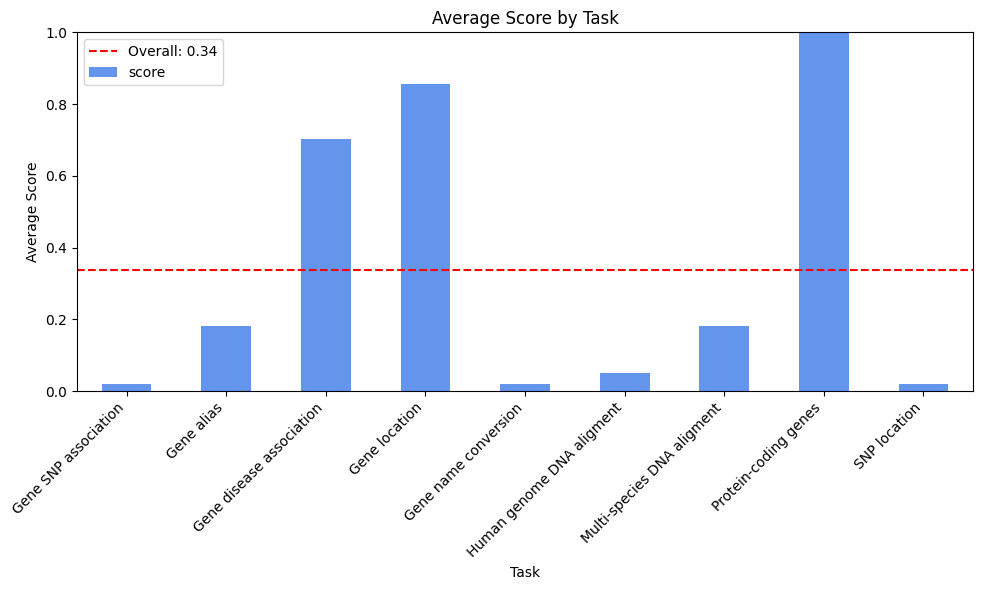

In [22]:
# 7.3 Create a bar chart of the scores by task with a horizontal line for the overall score
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
score_by_task.plot(kind='bar', color='cornflowerblue')
plt.axhline(y=overall_score, color='red', linestyle='--', label=f'Overall: {overall_score:.2f}')
plt.title("Average Score by Task")
plt.xlabel("Task")
plt.ylabel("Average Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

